# Portfolio Mean-Variance Optimization
### By Justin Jimenez    

## Abstract

Possibly one of the worst mistakes that any trader or investor could make would be to place all of their capital into a single position. Though the effective degree of diversification is frequently contended and subject to personal opinion, there is no doubt that some systematic approach to portfolio allocation should be implemented. Of the many means of portfolio allocation and optimization, this notebook aims to investigate the effects of Markowitz mean-variance optimization. This report will attempt to present the affects of investing in an increasing quantity low-covaried assets by portraying the efficient frontier of a hypothetical portfolio.

## Background
The Markowitz mean-variance optimization approach determines the ideal combination of equity allocations for each position in a  portfolio. It considers the relationship between the expected returns and the covariance of an asset with others within the portfolio. The optimization will provide a series of potential portfolio distributions whose efficient frontier will provide the highest estimated return for a given amount of risk, or the lowest risk for a given estimated return (see below).

## Step 1 - Calculating Average Expected Returns

The first step in analyzing this method of optimization is to calculate the average expected returns for the assets to be held in the portfolio.

We'll start with importing some key libraries for organizing and working with data (pandas, matplotlib, seaborn, and numpy) along with yfinance to import historical data. 


In [426]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import random
import cvxopt as opt
from cvxopt import blas, solvers

three_tickers = ["GOOG", "HPQ", "CMCSA"]
def expected_return(tickers):
    historical_data_object = []
    expected_returns_avg = pd.DataFrame()
    returns_quarterly = pd.DataFrame()
    [historical_data_object.append(yf.Ticker(f"{ticker}")) for ticker in tickers]
    for obj in historical_data_object:
        symbol = obj.info['symbol']
        hist = obj.history(period = "10y", auto_adjust = True, interval = "3mo").dropna()
        return_quarterly = hist.Close.pct_change().dropna()
        returns_quarterly[symbol] = return_quarterly
    expected_returns_avg[0] = returns_quarterly.mean(axis=0)
    #expected_returns_avg = expected_returns_avg.transpose()
    
    return expected_returns_avg, returns_quarterly

expected_returns_avg, returns_quarterly = expected_return(three_tickers)
print(expected_returns_avg)

              0
GOOG   0.059953
HPQ    0.038774
CMCSA  0.047734


This gives us the expected average quarterly return of each symbol in the portfolio. In order to calculate the average expected return of the entire portfolio, we need to assign weight values to each symbol to determine what percentage of the portfolio equity would be allocated to each symbol. The weight of the asset, $\omega_n$, is the fraction of portfolio equity assigned to the asset - $c_n$ - divided by the total portfolio equity (the denominator below).

$\omega_n = \frac{c_n}{total}$ 

The expected return is then the sum of the product of each asset's average expected return with it's weight:

$\sum_{i=1}^{n} \omega_n * R_n$

As an example, we can check the expected average portfolio return with an equal weight distribution as follows:

In [427]:
equal_weight_value = 1/len(expected_returns_avg[0])
expected_portfolio_return = 0
for avg_return in expected_returns_avg[0]:
    expected_portfolio_return += equal_weight_value * avg_return
print(expected_portfolio_return)

0.048820274589583004


## Step 2  - Calculating Risk

One of the ways of calculating a position's risk is to assess the variance of it's return. If the return varies significantly over time, the investment could be considered risky. Assets with low variance of return are less risky, but often provide a relatively smaller return. 

In addition to calculating the variance risk of each individual asset, it is also important to assess the covariance risk among all assets held in the portfolio. Two assets that have a high factor of covariance will respond similarly to market forces, effectively mitigating any effort at minimizing risk through diversification. 

The covariance is calculated as a matrix symmetric about the diagonal, where the diagonal values are the variance of each asset.

$$\begin{bmatrix} \sigma_1 & \sigma_{1,2} & \sigma_{1,3} \\ \sigma_{1,2} & \sigma_2 & \sigma_{2,3} \\ \sigma_{1,3} & \sigma_{2,3} & \sigma_{3} \end{bmatrix}$$

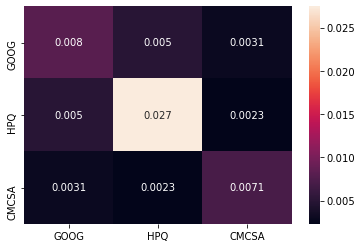

In [428]:
returns_cov = returns_quarterly.cov()
sns.heatmap(returns_cov, annot=True)
plt.show()

You can see from the heat map that HPQ and GOOG have the highest covariance in the portfolio.

## Step 3 - Finding the Efficient Frontier

The next step is a bit advanced. We need to create a function that will generate a list of possible portfolios with random weight distributions so that we can find the best return at each level of risk.

The following function (sourced from a Codecademy tutorial) generates a DataFrame of random portfolio.

In [429]:
def return_portfolios(expected_returns, cov_matrix):
  np.random.seed(1)
  port_returns = []
  port_volatility = []
  stock_weights = []
    
  selected = (expected_returns.axes)[0]
    
  num_assets = len(selected) 
  num_portfolios = 5000
    
  for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, expected_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)
    
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
  for counter,symbol in enumerate(selected):
    portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
  df = pd.DataFrame(portfolio)
    
  column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
  df = df[column_order]
   
  return df

Using the function would generate a df that looks like:

In [430]:
random_portfolios = return_portfolios(expected_returns_avg,returns_cov)
print(random_portfolios.head().round(4))

                  Returns  Volatility  GOOG Weight  HPQ Weight  CMCSA Weight
0   [0.04653980203085401]      0.1201       0.3666      0.6333        0.0001
1  [0.052128399402434716]      0.0839       0.5584      0.2711        0.1705
2  [0.046850536853352304]      0.0862       0.2006      0.3721        0.4273
3   [0.04945477926728967]      0.0778       0.3279      0.2551        0.4170
4   [0.04289641615538757]      0.1380       0.1842      0.7911        0.0247


Now that we have a list of possible portfolios, we can plot them:

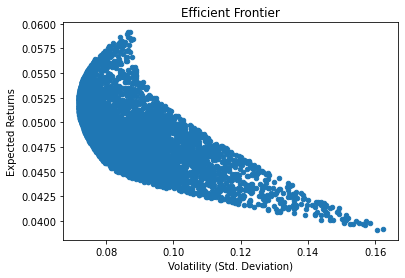

In [431]:
random_portfolios.plot.scatter(x='Volatility',y='Returns')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

This yields a clear depiction of of the best expected average return of the portfolio at each increment of volatility risk (the upper boundary of the scatter plot). However, we can visualize this more clearly using a function that returns these optimal portfolios (again, sourced from Codecademy) and creating an overlying plot.

In [432]:
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.values)

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

     pcost       dcost       gap    pres   dres
 0: -4.7877e-02 -1.0605e+00  1e+00  0e+00  2e+00
 1: -4.8040e-02 -7.0457e-02  2e-02  8e-17  5e-02
 2: -5.7376e-02 -6.0367e-02  3e-03  6e-16  3e-03
 3: -6.0226e-02 -6.0264e-02  4e-05  2e-16  2e-05
 4: -6.0255e-02 -6.0255e-02  4e-07  2e-16  2e-07
 5: -6.0255e-02 -6.0255e-02  4e-09  2e-16  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.7834e-02 -1.0604e+00  1e+00  0e+00  2e+00
 1: -4.7997e-02 -7.0432e-02  2e-02  6e-17  5e-02
 2: -5.7328e-02 -6.0319e-02  3e-03  2e-16  3e-03
 3: -6.0176e-02 -6.0214e-02  4e-05  2e-16  2e-05
 4: -6.0205e-02 -6.0205e-02  4e-07  3e-16  2e-07
 5: -6.0205e-02 -6.0205e-02  4e-09  1e-16  2e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.7785e-02 -1.0604e+00  1e+00  2e-16  2e+00
 1: -4.7950e-02 -7.0403e-02  2e-02  1e-16  5e-02
 2: -5.7273e-02 -6.0264e-02  3e-03  3e-16  3e-03
 3: -6.0120e-02 -6.0158e-02  4e-05  1e-16  2e-05
 4: -6.0149e-02 -6.0149e

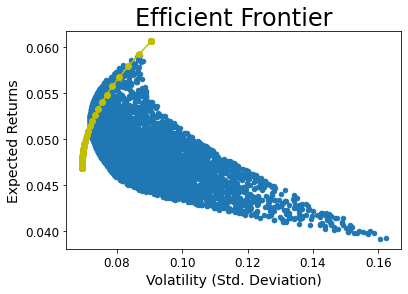

In [433]:
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
plt.show()

Now we can analyze the effects of changing the quantity of assets. We start by finding the efficient frontier given a portfolio with five assets and one with ten.

In [434]:
five_tickers = ["GOOG", "HPQ", "CMCSA", "BAC", "QQQ"]
expected_returns_five, returns_quarterly_five = expected_return(five_tickers)
returns_cov_five = returns_quarterly_five.cov()
weights_five, returns_five, risks_five = optimal_portfolio(returns_quarterly_five[1:])

ten_tickers = ["SPY", "QQQ", "BND", "GLD", "BAC", "CMCSA", "GOOG", "F", "HPQ", "T"]
expected_returns_ten, returns_quarterly_ten = expected_return(ten_tickers)
returns_cov_ten = returns_quarterly_ten.cov()
weights_ten, returns_ten, risks_ten = optimal_portfolio(returns_quarterly_ten[1:])

     pcost       dcost       gap    pres   dres
 0: -4.9180e-02 -1.0605e+00  1e+00  0e+00  3e+00
 1: -4.9283e-02 -7.0458e-02  2e-02  4e-17  6e-02
 2: -5.4458e-02 -6.0428e-02  6e-03  2e-16  1e-02
 3: -5.9960e-02 -6.0542e-02  6e-04  1e-15  7e-18
 4: -6.0252e-02 -6.0258e-02  6e-06  1e-16  6e-18
 5: -6.0255e-02 -6.0255e-02  6e-08  1e-16  3e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.9144e-02 -1.0604e+00  1e+00  2e-16  3e+00
 1: -4.9247e-02 -7.0432e-02  2e-02  2e-16  6e-02
 2: -5.4422e-02 -6.0387e-02  6e-03  2e-16  1e-02
 3: -5.9909e-02 -6.0491e-02  6e-04  2e-15  7e-18
 4: -6.0202e-02 -6.0208e-02  6e-06  2e-16  1e-17
 5: -6.0205e-02 -6.0205e-02  6e-08  1e-16  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.9104e-02 -1.0604e+00  1e+00  2e-16  3e+00
 1: -4.9208e-02 -7.0404e-02  2e-02  6e-17  6e-02
 2: -5.4382e-02 -6.0341e-02  6e-03  2e-16  1e-02
 3: -5.9851e-02 -6.0434e-02  6e-04  1e-15  4e-18
 4: -6.0146e-02 -6.0152e

 6:  2.3752e-01  2.3752e-01  6e-08  2e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.0127e-01 -7.7977e-01  1e+00  0e+00  3e+00
 1:  2.9045e-01  2.2581e-01  6e-02  1e-16  2e-01
 2:  2.7479e-01  2.6720e-01  8e-03  1e-16  3e-03
 3:  2.7243e-01  2.7163e-01  8e-04  2e-16  3e-16
 4:  2.7219e-01  2.7212e-01  8e-05  1e-16  8e-17
 5:  2.7218e-01  2.7217e-01  7e-06  7e-18  2e-16
 6:  2.7218e-01  2.7218e-01  9e-08  1e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.4032e-01 -7.4298e-01  1e+00  2e-16  3e+00
 1:  3.2896e-01  2.6424e-01  6e-02  1e-16  2e-01
 2:  3.1362e-01  3.0620e-01  7e-03  1e-16  3e-03
 3:  3.1131e-01  3.1053e-01  8e-04  1e-16  2e-16
 4:  3.1107e-01  3.1099e-01  8e-05  2e-16  2e-16
 5:  3.1106e-01  3.1105e-01  8e-06  1e-16  2e-16
 6:  3.1105e-01  3.1105e-01  1e-07  1e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.8397e-01 -7.0145e-01  1e+00  1e-16  3e+00


     pcost       dcost       gap    pres   dres
 0: -3.5989e-02 -1.0605e+00  1e+00  0e+00  4e+00
 1: -3.6625e-02 -7.0473e-02  3e-02  6e-17  1e-01
 2: -5.5092e-02 -6.1963e-02  7e-03  4e-16  3e-17
 3: -6.0051e-02 -6.0477e-02  4e-04  1e-16  3e-17
 4: -6.0240e-02 -6.0244e-02  4e-06  2e-16  2e-17
 5: -6.0242e-02 -6.0242e-02  4e-08  2e-16  2e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.5968e-02 -1.0605e+00  1e+00  0e+00  4e+00
 1: -3.6603e-02 -7.0451e-02  3e-02  7e-17  1e-01
 2: -5.5043e-02 -6.1931e-02  7e-03  1e-16  3e-17
 3: -6.0000e-02 -6.0424e-02  4e-04  1e-16  3e-17
 4: -6.0190e-02 -6.0195e-02  4e-06  2e-16  3e-17
 5: -6.0192e-02 -6.0192e-02  4e-08  2e-16  3e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.5944e-02 -1.0604e+00  1e+00  2e-16  4e+00
 1: -3.6578e-02 -7.0427e-02  3e-02  1e-16  1e-01
 2: -5.4989e-02 -6.1894e-02  7e-03  2e-16  3e-17
 3: -5.9944e-02 -6.0365e-02  4e-04  2e-16  3e-17
 4: -6.0134e-02 -6.0139e

 3: -3.7236e-02 -3.8306e-02  1e-03  2e-16  2e-17
 4: -3.7711e-02 -3.7765e-02  5e-05  1e-16  1e-17
 5: -3.7741e-02 -3.7742e-02  9e-07  1e-16  1e-17
 6: -3.7742e-02 -3.7742e-02  1e-08  2e-16  1e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.4895e-02 -1.0466e+00  1e+00  4e-16  4e+00
 1: -2.5251e-02 -5.6209e-02  3e-02  1e-16  1e-01
 2: -3.2639e-02 -3.9274e-02  7e-03  1e-16  2e-17
 3: -3.5292e-02 -3.6440e-02  1e-03  2e-17  1e-17
 4: -3.5767e-02 -3.5818e-02  5e-05  2e-16  1e-17
 5: -3.5805e-02 -3.5806e-02  6e-07  8e-17  7e-18
 6: -3.5806e-02 -3.5806e-02  6e-09  1e-16  9e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.3786e-02 -1.0448e+00  1e+00  0e+00  4e+00
 1: -2.4138e-02 -5.4459e-02  3e-02  6e-17  1e-01
 2: -3.0846e-02 -3.6886e-02  6e-03  1e-16  2e-17
 3: -3.3223e-02 -3.4299e-02  1e-03  7e-17  1e-17
 4: -3.3672e-02 -3.3754e-02  8e-05  8e-17  1e-17
 5: -3.3725e-02 -3.3728e-02  3e-06  1e-16  1e-17
 6: -3.3728e-02 -3.3728

 1:  7.4409e-02 -5.5954e-02  1e-01  2e-16  5e-01
 2:  2.8768e-02  5.5708e-03  2e-02  2e-16  8e-03
 3:  1.9014e-02  1.5224e-02  4e-03  1e-16  1e-16
 4:  1.7101e-02  1.6748e-02  4e-04  1e-16  7e-17
 5:  1.6850e-02  1.6834e-02  2e-05  1e-16  7e-17
 6:  1.6841e-02  1.6841e-02  5e-07  1e-16  6e-17
 7:  1.6841e-02  1.6841e-02  5e-09  2e-16  5e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.0476e-01 -1.0771e+00  1e+00  3e-16  4e+00
 1:  7.9050e-02 -5.2346e-02  1e-01  2e-16  5e-01
 2:  3.3165e-02  9.1602e-03  2e-02  1e-16  2e-02
 3:  2.2571e-02  1.8699e-02  4e-03  1e-16  3e-16
 4:  2.0537e-02  2.0159e-02  4e-04  2e-16  1e-16
 5:  2.0264e-02  2.0245e-02  2e-05  1e-16  1e-16
 6:  2.0253e-02  2.0252e-02  1e-06  1e-16  8e-17
 7:  2.0253e-02  2.0253e-02  1e-07  2e-16  1e-16
 8:  2.0253e-02  2.0253e-02  2e-09  1e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.1270e-01 -1.0768e+00  1e+00  0e+00  4e+00
 1:  8.3656e-02 -4.7808

Then we can plot the efficient frontier for each portfolio along with the scatter of random portfolio distributions.

## Three Asset Portfolio

The median expected return is 4.878%
The median variance would be 0.07
The weight distribution of the portfolio with the best returns would be:
The weight of GOOG is [0.99999985].
The weight of HPQ is [7.90135748e-08].
The weight of CMCSA is [7.43381186e-08].


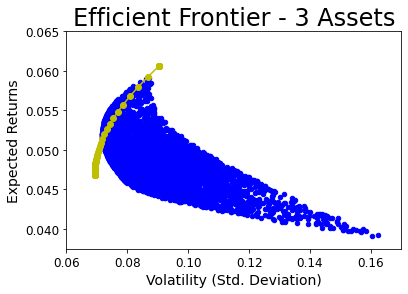

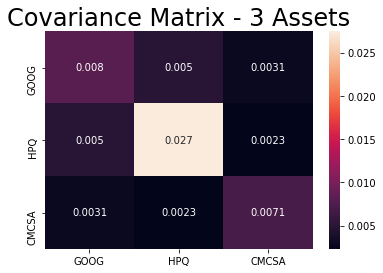

In [435]:
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12, color='blue')
print(f"The median expected return is {round(np.median(returns)*100,3)}%")
print(f"The median variance would be {round(np.median(risks),3)}")
print("The weight distribution of the portfolio with the best returns would be:")
[print(f"The weight of {asset} is {weights[three_tickers.index(asset)]}.") for asset in three_tickers]
plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier - 3 Assets', fontsize=24)
plt.xlim([0.06, 0.17])
plt.ylim([0.0375, 0.065])
plt.show()
sns.heatmap(returns_cov, annot=True)
plt.title('Covariance Matrix - 3 Assets', fontsize=24)
plt.show()

## Five Asset Portfolio

The median expected return is 4.802%
The median variance would be 0.06
The weight distribution of the portfolio with the best returns would be:
The weight of GOOG is [0.99999772].
The weight of HPQ is [4.62887382e-07].
The weight of CMCSA is [4.54197187e-07].
The weight of BAC is [7.40176827e-07].
The weight of QQQ is [6.26293066e-07].


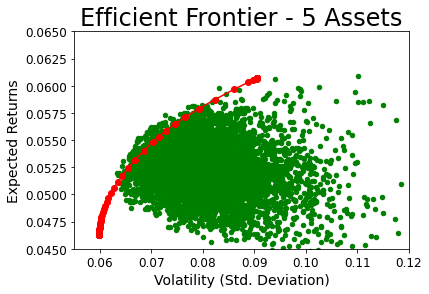

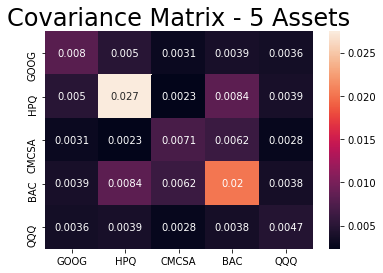

In [436]:
random_portfolios_five = return_portfolios(expected_returns_five,returns_cov_five)
random_portfolios_five.plot.scatter(x='Volatility', y='Returns', fontsize=12, color='green')
print(f"The median expected return is {round(np.median(returns_five)*100,3)}%")
print(f"The median variance would be {round(np.median(risks_five),3)}")
print("The weight distribution of the portfolio with the best returns would be:")
[print(f"The weight of {asset} is {weights_five[five_tickers.index(asset)]}.") for asset in five_tickers]
plt.plot(risks_five, returns_five, 'r-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier - 5 Assets', fontsize=24)
plt.xlim([0.055, 0.12])
plt.ylim([0.045, 0.065])
plt.show()
sns.heatmap(returns_cov_five, annot=True)
plt.title('Covariance Matrix - 5 Assets', fontsize=24)
plt.show()

## Ten Asset Portfolio

The median expected return is 2.508%
The median variance would be 0.026
The weight distribution of the portfolio with the best returns would be:
The weight of SPY is [9.27561146e-08].
The weight of QQQ is [1.00585374e-07].
The weight of BND is [4.58443234e-08].
The weight of GLD is [4.24047978e-08].
The weight of BAC is [2.02083106e-07].
The weight of CMCSA is [1.04543588e-07].
The weight of GOOG is [0.99999919].
The weight of F is [5.93795804e-08].
The weight of HPQ is [1.08256482e-07].
The weight of T is [5.06868363e-08].


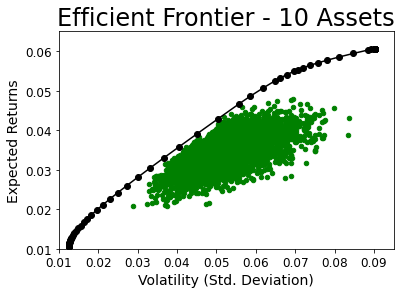

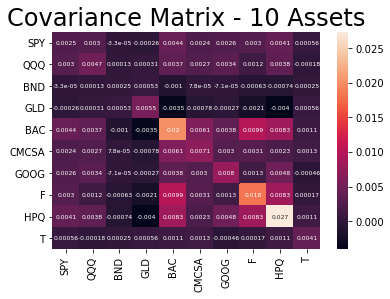

In [437]:
random_portfolios_ten = return_portfolios(expected_returns_ten,returns_cov_ten)
random_portfolios_ten.plot.scatter(x='Volatility', y='Returns', fontsize=12, color='green')
print(f"The median expected return is {round(np.median(returns_ten)*100,3)}%")
print(f"The median variance would be {round(np.median(risks_ten),3)}")
print("The weight distribution of the portfolio with the best returns would be:")
[print(f"The weight of {asset} is {weights_ten[ten_tickers.index(asset)]}.") for asset in ten_tickers]
plt.plot(risks_ten, returns_ten, 'k-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier - 10 Assets', fontsize=24)
plt.xlim([0.01, 0.095])
plt.ylim([0.01, 0.065])
plt.show()

#mask = np.triu(returns_cov_ten)
sns.heatmap(returns_cov_ten, annot=True, annot_kws={"fontsize":6})
plt.title('Covariance Matrix - 10 Assets', fontsize=24)
plt.show()

## Findings

We can see from the weight distributions that the optimal returns are achieved when the majority of the portfolio is allocated to the asset with the highest expected returns. Conversely, the portfolio with the least risk will have a weight distribution primarily allocated to the asset with the lowest variance.
In addition, by overlaying the efficient frontiers of these three portfolios, we find that adding low-covaried assets to the portfolio achieves two notable effects:

1. There are more options for portfolio distributions with lower variance risk.
2. At each increment of expected return, the volatility is reduced; conversely, at each increment of volatility, the expected return is increased.

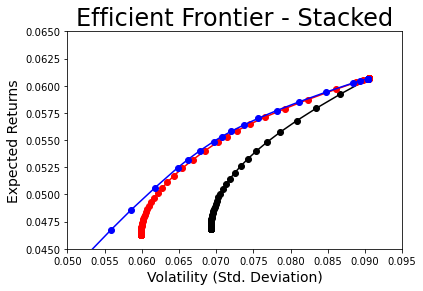

In [438]:
plt.plot(risks, returns, 'k-o')
plt.plot(risks_five, returns_five, 'r-o')
plt.plot(risks_ten, returns_ten, 'b-o')
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier - Stacked', fontsize=24)
plt.xlim([0.05, 0.095])
plt.ylim([0.045, 0.065])
plt.show()

## Relevant Considerations

You may have noticed that the efficient frontiers do not quite align with the upper boundary of the scatter plot of random portfolios. This would suggest that the calculated efficient frontiers would not provide the theoretically optimal return at each increment of volatility.

I attempted to troubleshoot why this was the case, but I found that the results were similar from other studies.

I did find one interesting repository discussing the shortcomings of mean-variance optimization. It is a python package that finds the efficient frontier based on Monte Carlo simulated returns. The documentation is not ideal, stating:

In this model, portfolio selection is only based the first two moments of the random return. This is also true for some other more sophisticated models (Black–Litterman, etc).

```
Here the variance is chosen as risk measure, which choose non-efficient portfolios when the random return is not Gaussian.

Is it the return normally distributed in the real world?

We know it is not (skewed, fat tail, you name it).

Can PyMCEF handle this situation?

PyMCEF use risk measures that will produce efficient portfolios according to stochastic dominance theory. (Hadar and Russell 1969, Hanoch and Levy 1969 and Rothschild and Stiglitz 1970)
Two risk measures are used in PyMCEF

Absolute semi-deviation (Ogryczak and Ruszczyński 1999)
Fixed-target under-performance (Fishburn 1977)
```

At the time of writing this, I am not knowledgeable enough to attest to the fundamentals or efficacy of stochastic dominance theory. I hope that one day I will be able to dive into this to make the subject matter more approachable, but for now I'll leave this repository as a reference for anyone interested in further researching the subject.

## References
1. https://www.investopedia.com/terms/m/meanvariance-analysis.asp
2. https://www.investopedia.com/terms/c/covariance.asp
3. https://www.nasdaq.com/glossary/m/mean-variance-criterion
4. https://www.effisols.com/basics/MVO.htm
5. https://pypi.org/project/yfinance/
6. https://www.codecademy.com/paths/finance-python/tracks/visualizing-finance-data/modules/portfolio-optimization/lessons/mv-portfolio-optimization/exercises/review
7. https://github.com/zhangyi-hu/pymcef/blob/master/examples/1.%20When%20mean%20variance%20models%20fail.ipynb

## Revision Log

1. First created on 9/22/2021